# Spec2Vec - Find similar compounds for unknown substances
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.
With spec2vec, however, it also becomes possible to search large datasets only based on Spec2Vec similarities. This allows to also find suggestions for compounds which are not in the library.

In [2]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "AllPositive"
+ 112956 spectra with positive ionmode
+ 95320 of which with >= 10 peaks (only those will be used here!)

In [3]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


### Post-process data
Run ``matchms`` based processing pipeline:
+ Normalize peaks
+ remove spectra with <10 peaks
+ reduce number of peaks to reduce noise and create more homogeneous document sizes
+ remove low intensity peaks 
+ add neutral losses

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

In [5]:
print("After processing {} spectra remain.".format(len(spectrums_s2v)))

After processing 95320 spectra remain.


## Inspect annotations

In [8]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))
    
print("Found {} spectra with Inchikey".format(len([x for x in Inchikeys if x])),
     "(out of {}).".format(len(spectrums_s2v)))

Found 77092 spectra with Inchikey (out of 95320).


In [6]:
Inchikeys[:20]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 '',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'NAIKIJSSBJHCBL-VIPNTUGYSA-N',
 '',
 '',
 'GWGKNTICBPKKKW-LBBUGJAGSA-N',
 'NAIKIJSSBJHCBL-IPUGVWFUSA-N',
 'NAIKIJSSBJHCBL-IPUGVWFUSA-N',
 'GWGKNTICBPKKKW-LBBUGJAGSA-N',
 'KZVHAGNFWJIOMX-YIEYWENTSA-N']

In [9]:
inchikeys_pd = pd.Series([x for x in Inchikeys])
inchikeys_pd.str[:14].value_counts()[:10]

                  18226
NEGQHKSYEYVFTD      432
SULIDBRAXVDKBU      426
IQGPMZRCLCCXAG      308
WTJKGGKOPKCXLL      295
IIZPXYDJLKNOIY      235
RWKUXQNLWDTSLO      234
QIBZFHLFHCIUOT      225
ZAYXPDDGEIJGGW      212
QJWDAOSZZYVBJZ      210
dtype: int64

In [10]:
inchikeys_notempty = inchikeys_pd[[i for i,x in enumerate(inchikeys_pd) if x]]
inchikeys_notempty.head()

0    IYDKWWDUBYWQGF-NNAZGLEUSA-N
1    KNGPFNUOXXLKCN-ZNCJFREWSA-N
2    WXDBUBIFYCCNLE-NSCMQRKRSA-N
3    CGZKSPLDUIRCIO-RPCRKUJJSA-N
5    USXIYWCPCGVOKF-LERJCCFDSA-N
dtype: object

Text(0.5, 1.0, 'Histogram of spectra per unique InchiKey (first 14 characters)')

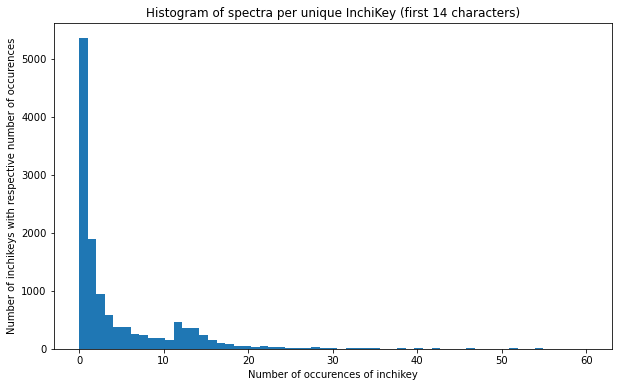

In [14]:
plt.figure(figsize=(10,6))
plt.hist(inchikeys_notempty.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.title("Histogram of spectra per unique InchiKey (first 14 characters)")

## Select query spectra (which will be removed from library)
+ Randomly select 200 InchiKeys
+ Select all spectra with those InchiKeys 

In [16]:
unique_inchikeys = inchikeys_notempty.str[:14].unique()
print("Found {} unique InchiKeys in the dataset (counting first 14 characters only)".format(unique_inchikeys.shape[0]))

Found 12846 unique InchiKeys in the dataset (counting first 14 characters only)


In [17]:
num_inchikeys = 200

np.random.seed(0) # to make it reproducible
selected_inchikeys = np.random.choice(unique_inchikeys, num_inchikeys, replace=False)
selected_inchikeys[:25]

array(['USEXQPWLCGBYNT', 'URAYPUMNDPQOKB', 'OGNSCSPNOLGXSM',
       'GNPWSZMDKPTDLE', 'VYFYYTLLBUKUHU', 'WDKPRHOCWKLQPK',
       'DMJNNHOOLUXYBV', 'CXOXHMZGEKVPMT', 'HTCVSLIHSFBUEL',
       'ROWKODQLOIEBHL', 'RJECHNNFRHZQKU', 'XIYSEKITPHTMJT',
       'ZDYHKOFGYRLNSW', 'GKHCBYYBLTXYEV', 'QPNFBUARICHXGG',
       'BECNNJLLIXQSGY', 'NOHZAMDNJBVHTA', 'DVLLGHPCJPEUHA',
       'CLNILJPYOXIKRO', 'BGLMHEUNVVQFLX', 'HBUBKKRHXORPQB',
       'UTZJMFNIKVHUDP', 'BWHHTYGQTQWLHV', 'MNKNQKOOKLVXDB',
       'DEJPAJWPCTUPPL'], dtype=object)

In [18]:
selected_spectra = []

for inchikey in selected_inchikeys:
    matches = inchikeys_notempty[inchikeys_notempty.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

print(len(selected_spectra), "spectra were found with Inchikeys from selected_inchikeys list.")

1030 spectra were found with Inchikeys from selected_inchikeys list.


### Check if that worked

In [19]:
ID = 0
inchikey = selected_inchikeys[0]
print(inchikey)

matches_test = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values

for idx in matches_test:
    print(spectrums_s2v[idx].get("inchikey")[:14])

USEXQPWLCGBYNT
USEXQPWLCGBYNT
USEXQPWLCGBYNT


In [20]:
print(selected_spectra[:25])

[66105, 95146, 18446, 63328, 63329, 63330, 94926, 3117, 18524, 24773, 25253, 25709, 63340, 63341, 63342, 63343, 63344, 63731, 63732, 63733, 63734, 63735, 64942, 64943, 67682]


Text(0.5, 1.0, 'Histogram of spectra per unique InchiKey (first 14 characters)')

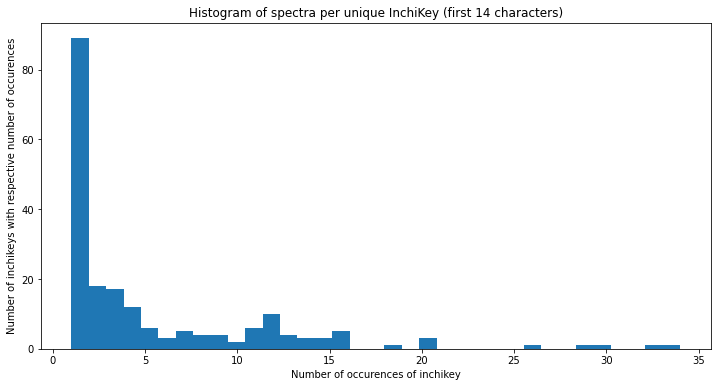

In [21]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14][selected_spectra].value_counts(), 35)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.title("Histogram of spectra per unique InchiKey (first 14 characters)")

In [25]:
selected_inchikey_counts = inchikeys_pd.str[:14][selected_spectra].value_counts()
print("Mean number of spectra per Inchikey:", np.mean(selected_inchikey_counts))
print("Median number of spectra per Inchikey:", np.median(selected_inchikey_counts))
print("Maximum number of spectra per Inchikey:", np.max(selected_inchikey_counts))

Mean number of spectra per Inchikey: 5.15
Median number of spectra per Inchikey: 2.0
Maximum number of spectra per Inchikey: 34


## Train new model on AllPositive dataset WITHOUT selected spectra
+ Create a ``SpectrumDocument`` for each spectrum:
+ ``documents_library`` containing only spectra without the selected Inchikeys
+ ``documents_query`` containing only spectra **with** the selected Inchikeys
+ Train model on library documents (``Careful: Not allowed to contain any spectra with selected query Inchikeys!``)

In [27]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [28]:
documents_library = [SpectrumDocument(s, n_decimals=2) for i, s in enumerate(spectrums_s2v) if i not in selected_spectra]

In [147]:
library_inchikeys = []
for doc in documents_library:
    library_inchikeys.append(doc._obj.get("inchikey"))
    
print("Found {} spectra with Inchikey".format(len([x for x in library_inchikeys if x])),
     "(out of {} library spectra).".format(len(documents_library)))

Found 76062 spectra with Inchikey (out of 94290 library spectra).


In [29]:
documents_query = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]

In [31]:
# Check dimensions
len(spectrums_s2v), len(documents_library), len(documents_query)

(95320, 94290, 1030)

In [250]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_unknown_compound_matching.model")

iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
model = train_new_word2vec_model(documents_library, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 5628790.5
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_unknown_compound_matching_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 4332522.5
  Epoch 3 of 20.Change in loss after epoch 3: 3885474.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_unknown_compound_matching_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 3564895.0
  Epoch 5 of 20.Change in loss after epoch 5: 2904324.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\matchms\data\trained_models\spec2vec_unknown_compound_matching_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 2789902.0
  Epoch 7 of 20.Change in loss after epoch 7: 2706990.0
  Epoch 8 of 20.Change in loss after epoch 8: 2632880.0
  Epoch 9 of 20.Change in loss after epoch 9: 25

## Actual library matching
+ Import ``library_matching`` function
+ Load pre-trained model
+ Generate query documents
+ Query those documents against the library

In [32]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))

In [33]:
from library_search import library_matching

#### Load word2vec model

In [34]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_unknown_compound_matching_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [35]:
documents_query[0]._obj.get("inchikey")

'USEXQPWLCGBYNT-UHFFFAOYSA-N'

### Correct a few (< 10) spectrums with missing precursor_mz

In [36]:
for i, spec in enumerate(spectrums_s2v):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

### Run Spec2Vec and parentmass based library matching for 1030 against 94290 spectra
+ ``library_matching`` will return one pandas ``DataFrame`` for every query, which contains the selected best candidates, their IDs and scores.
+ The word2vec model was trained on the library spectra and is now applied on the query spectra. This means that occationally some words (=peaks) will be unknown to the model. The missing weighted fraction will be reported during the library search. ``allowed_missing_percentage`` can be used to set the maximum allowed missing percentage.

In [37]:
found_matches = library_matching(documents_query, documents_library,
                                 model,
                                 presearch_based_on=["parentmass", "spec2vec-top10"],
                                 ignore_non_annotated=True,
                                 intensity_weighting_power=0.5,
                                 allowed_missing_percentage=20.0,
                                 cosine_tol=0.005,
                                 mass_tolerance=1.0)

Pre-selection includes spec2vec top 10.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.23%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.16%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.19%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.25%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.46%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 7.93%.
Found 3 word(s) missing in the model. Weighted fraction not covered is 0.56%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 0.42%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.12%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.21%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.28%.


In [38]:
# Check number of queries done
len(found_matches)

1030

### Inspect tables with found matches

In [39]:
found_matches[104].sort_values(by=["s2v_score"], ascending=False)

,mass_match,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,s2v_score
13580,0.0,0.959048,19,0.959048,19,0.894109
14776,0.0,0.943371,17,0.943371,17,0.840442
14958,0.0,0.954251,15,0.954251,15,0.836036
14959,0.0,0.962202,20,0.962206,21,0.828903
77774,0.0,0.946057,15,0.946057,15,0.824891
...,...,...,...,...,...,...
69128,1.0,0.000000,0,0.000000,0,-0.064105
37978,1.0,0.000000,0,0.000000,0,-0.083420
15254,1.0,0.000000,0,0.000000,0,-0.091607
69091,1.0,0.000000,0,0.000000,0,-0.093683


# Evaluate results
## Collect all top-10 matches based on Spec2Vec similarity
+ Select top-10 spec2vec score matches for every query
+ Get fingerprint-based reference scores for those suggested matches

Define get_mol_fingerprints function.

In [40]:
from matchms.utils import derive_fingerprint_from_inchi
from matchms.utils import derive_fingerprint_from_smiles

def get_mol_fingerprints(spectrums, fingerprint_type="daylight", nbits=2048):
    """Return molecular finterprints.
    """
    def _get_fingerprint_from_spectrum(spectrum):
        # First try to get fingerprint from smiles
        if spectrum is None:
            return None
        if spectrum.get("smiles", None):
            fingerprint = derive_fingerprint_from_smiles(spectrum.get("smiles"),
                                                         fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint

        # Second try to get fingerprint from inchi
        if spectrum.get("inchi", None):
            fingerprint = derive_fingerprint_from_inchi(spectrum.get("inchi"),
                                                        fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint  
        
    fingerprints = []
    for spec in spectrums:
        fingerprint = _get_fingerprint_from_spectrum(spec)
        fingerprints.append(fingerprint)
    
    return fingerprints

In [41]:
from matchms.similarity.vector_similarity_functions import jaccard_similarity_matrix

mol_sim_matches = []
list_sv2 = []
list_modcos = []

for ID in range(len(documents_query)):
    idx = found_matches[ID].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]
    
    if len(idx) > 0:
        fingerprint_query = get_mol_fingerprints([documents_query[ID]._obj], 
                                                     fingerprint_type="daylight", #morgan3", 
                                                     nbits=2048)
        fingerprint_matches = get_mol_fingerprints([documents_library[i]._obj for i in idx], 
                                                     fingerprint_type="daylight", #morgan3",  
                                                     nbits=2048)

        # Calculate similarities
        if fingerprint_query[0] is None:
            print("No fingerprint generated for query spectrum {}".format(ID))
        else:
            if np.sum([1 for x in fingerprint_matches if x is None]) > 0:
                print("Found {} not generated fingerprints in matches".format(np.sum([1 for x in fingerprint_matches if x is None])))
            exclude_empty_fps = [i for i, x in enumerate(fingerprint_matches) if x is not None]
            if len(fingerprint_matches) > 0 and len(fingerprint_query) > 0:
                Mtest = jaccard_similarity_matrix(np.asarray(fingerprint_query),
                                                   np.asarray([fingerprint_matches[i] for i in exclude_empty_fps]))
                mol_sim_matches.append(Mtest)
            else:
                mol_sim_matches.append(None)

            list_sv2.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['s2v_score'].values.tolist())
            list_modcos.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['mod_cosine_score'].values.tolist())

Found 1 not generated fingerprints in matches
Found 1 not generated fingerprints in matches
Found 1 not generated fingerprints in matches


#### Define a histogram plotting function

In [42]:
def histogram_found_matches(matches,
                            n_bins,
                            method = "ideal_pick",
                            sort_by_lst = None):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0,1,n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(8,7))
    
    nums = len(matches)
    if method == "ideal_pick": 
        # Chose best pick from condidate suggestions
        #hist, bin_edges = np.histogram(np.max(matches, axis=2), bins_lst)
        pick = []
        for i in range(nums):
            pick += [np.array(matches[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    elif method == 'argmax':
        if sort_by_lst is None:
            print("sort_by_lst list expected.")
        pick = []
        for i in range(nums):
            pick += [np.array(sort_by_lst[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    #plt.xlabel('best found molecular similarity among Spec2Vec top-10 suggestions \n (rdkit-2048 fingerprint --> jaccard score)')
    maxbar = np.max(100*hist/np.sum(hist))
    plt.yticks(10*np.arange(np.ceil(maxbar/10)), ["{}".format(10*x) for x in np.arange(np.ceil(maxbar/10))], fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of matches [%]', fontsize=16)
        
    return hist, bin_edges

[190 221 175  96 348]


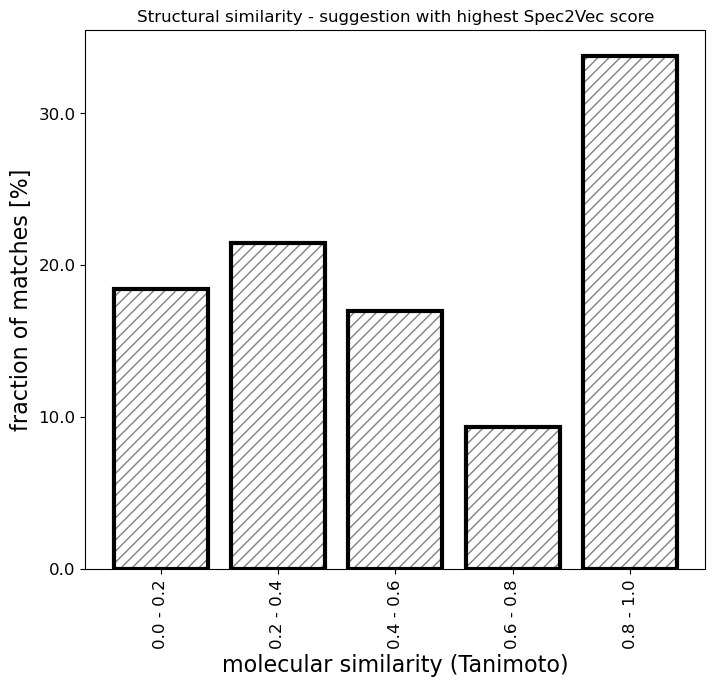

In [43]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'argmax', list_modcos)

print(hist)
plt.title("Structural similarity - suggestion with highest Spec2Vec score")
plt.savefig("Unknown_compound_matching_s2v_highest_score.pdf", bbox_inches='tight')

[ 51 152 199 141 487]


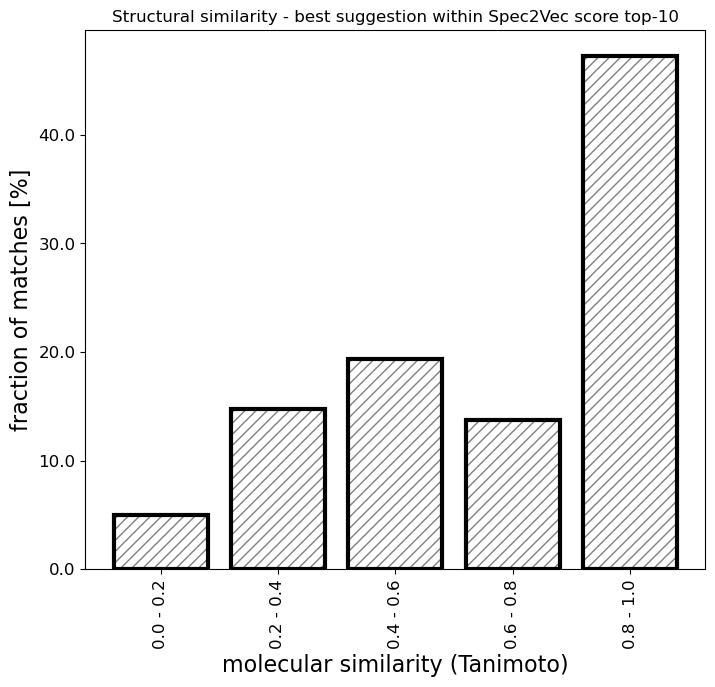

In [44]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'ideal_pick', list_modcos)

print(hist)
plt.title("Structural similarity - best suggestion within Spec2Vec score top-10")
plt.savefig("Unknown_compound_matching_s2v_ideal_pick.pdf", bbox_inches='tight')
plt.savefig("Unknown_compound_matching_s2v_ideal_pick.png", bbox_inches='tight')

## Inspect some suggestions in detail

In [54]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

In [50]:
def save_molecule_as_svg(filename, molecules):
    img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(400, 400))
    with open(filename, 'w') as f:
        f.write(img.data)

def save_img_as_svg(filename, img):
    with open(filename, 'w') as f:
        f.write(img.data)


 ---------- Query molecule ----------
C=CCC1OC(=O)CCN=C(O)C(C)N(C)C(=O)C(C(C)C)N(C)C(=O)C(C(C)CC)N=C(O)C2CCCN2C1=O


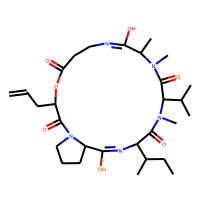

In [88]:
ID = 80  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
save_img_as_svg("molecule_query_{}.svg".format(ID), img)
img


 ---------- Suggested molecules ----------
CCC(C)C1NC(=O)C2CCCN2C(=O)C(CC(C)C)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
CCC(C)C1NC(=O)C2C(C)CCN2C(=O)C(CC(O)CO)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
CCC(C)C1NC(=O)C2CCCN2C(=O)C(CC(O)CO)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
[H]N1C(=O)C([H])(N(C(=O)C([H])(N(C(=O)C([H])(N([H])C(=O)[C@@]2([H])N(C(=O)[C@]([H])(OC(=O)C([H])([H])C1([H])[H])C([H])([H])C1([H])OC1([H])[H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H])C([H])([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H])C([H])([H])[H]
CCC(C)[C@@H]1C(=O)N([C@@H](C(=O)N([C@@H](C(=O)NCCC(=O)OC(C(=O)N2CCC[C@H]2C(=O)N1)CC(CCl)O)C)C)C(C)C)C
CCC(C)C1NC(=O)C2CCCN2C(=O)C(CC(O)CO)OC(=O)CCNC(=O)C(C)N(C)C(=O)C(C(C)C)N(C)C1=O
[H]OC(=O)C([H])(C([H])([H])[H])C([H])([H])[C@@]1([H])OC(=O)C([H])([H])C([H])([H])N([H])C(=O)C([H])(N(C(=O)C([H])(N(C(=O)C([H])(N([H])C(=O)[C@@]2([H])N(C1=O)C([H])([H])C([H])([H])C([H])([H])C2([H])[H])C([H])(C([H])([H

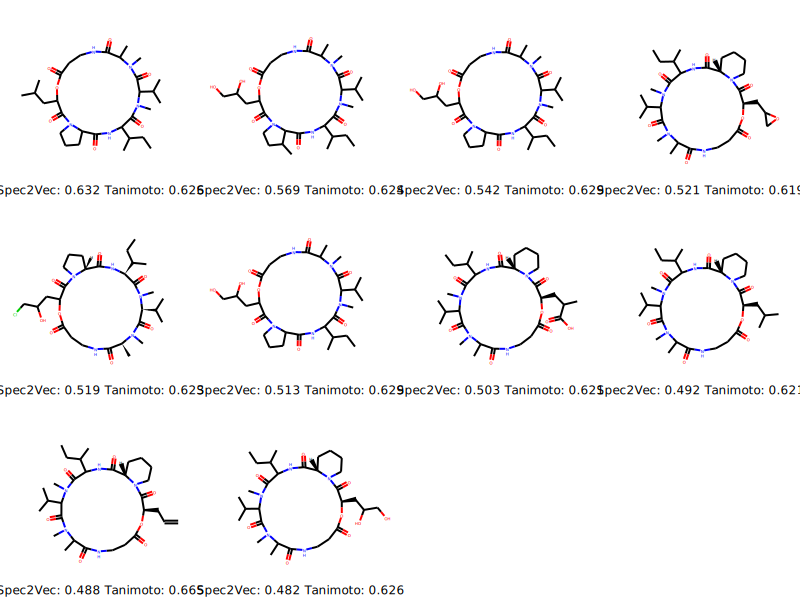

In [89]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
save_img_as_svg("found_molecules_query_{}.svg".format(ID), img)
img


 ---------- Query molecule ----------
c1(nc(nc(n1)OC)NCC)NC(C)(C)C


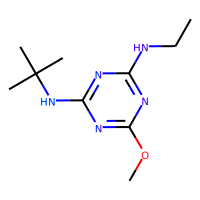

In [90]:
ID = 610  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
save_img_as_svg("molecule_query_{}.svg".format(ID), img)
img


 ---------- Suggested molecules ----------
c1(nc(nc(n1)OC)NCC)NC(CC)C
c1(nc(nc(n1)OC)NCC)NC(CC)C
c1(nc(nc(n1)OC)NCC)NC(CC)C
c1(nc(nc(n1)OC)NCC)NC(CC)C
c1(nc(nc(n1)OC)NCC)NC(CC)C
CCC(C)NC1=NC(=NC(=N1)NCC)OC
c1(nc(nc(n1)OC)NCC)NC(CC)C
c1(nc(nc(n1)OC)NCC)NC(CC)C
c1(nc(nc(n1)OC)NCC)NC(CC)C
CCC(C)NC1=NC(=NC(=N1)NCC)OC


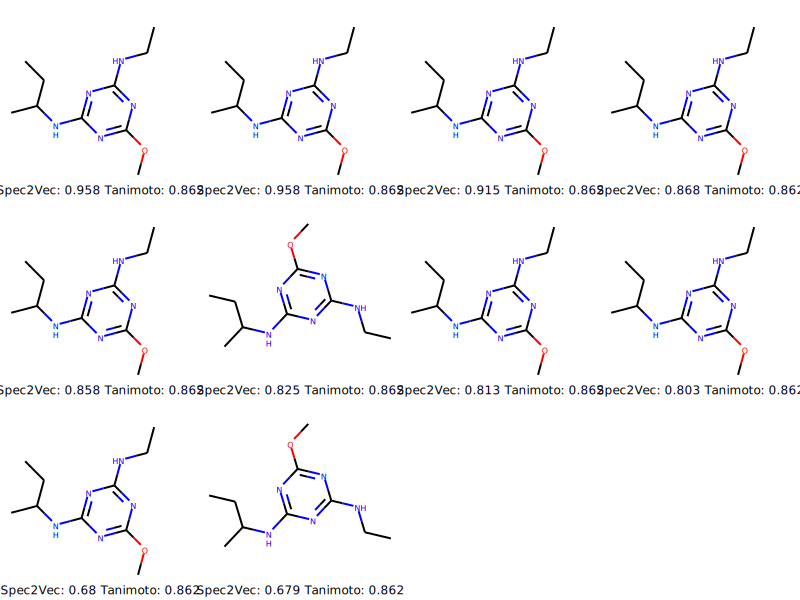

In [91]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
save_img_as_svg("found_molecules_query_{}.svg".format(ID), img)
img


 ---------- Query molecule ----------
COc1cc(OC2OC(CO)C(O)C(O)C2O)cc2c1C(c1c(O)cc(O)c(CC=C(C)C)c1OC1OC(CO)C(O)C(O)C1O)C(O)C(c1ccc(O)cc1)O2


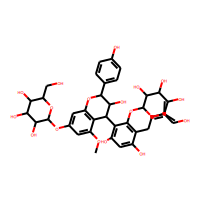

In [92]:
ID = 700  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
save_img_as_svg("molecule_query_{}.svg".format(ID), img)
img


 ---------- Suggested molecules ----------
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)\C=C/C2=CC=C(O)C=C2)C(=O)OCC3=CC=C(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)C=C3
CC(C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(OC(=O)/C=C/c1ccc(O)cc1)C(=O)OCc1ccc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)cc1
CC(C)(O[C@@H

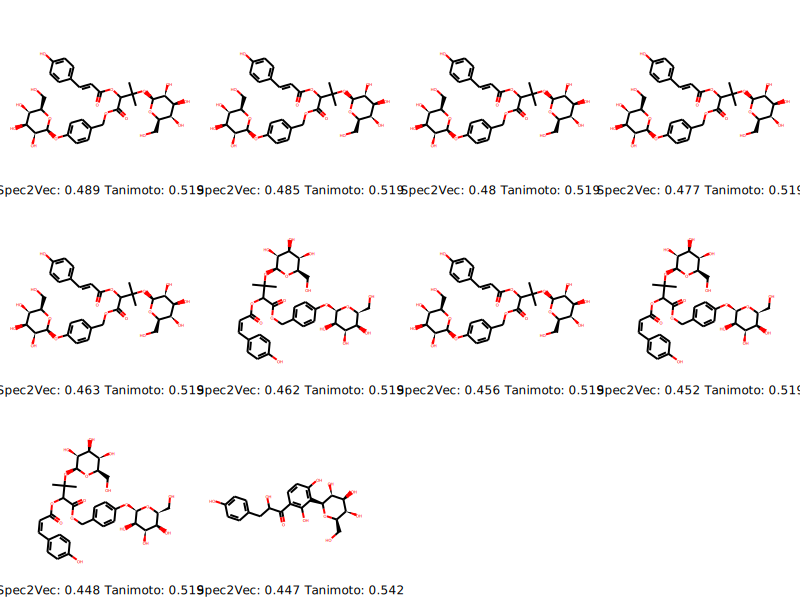

In [93]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
save_img_as_svg("found_molecules_query_{}.svg".format(ID), img)
img


 ---------- Query molecule ----------
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@]1(C)[C@@H](C[C@H](O)C[C@H]1O)C[C@H]3O


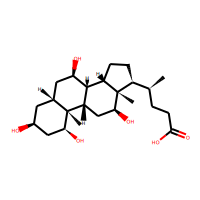

In [94]:
ID = 850  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
save_img_as_svg("molecule_query_{}.svg".format(ID), img)
img


 ---------- Suggested molecules ----------
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)[C@H](O)[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@@]21C
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@@H]1[C@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@@H]1[C@@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1[C@@H](O)[C@@H]3O
C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)[C@H](O)[C@@H]4C[C@H](O)CC[C@]4(C)[C@H]3C[C@H](O)[C@@]21C
C[C@H](CCC(=O)O)[C

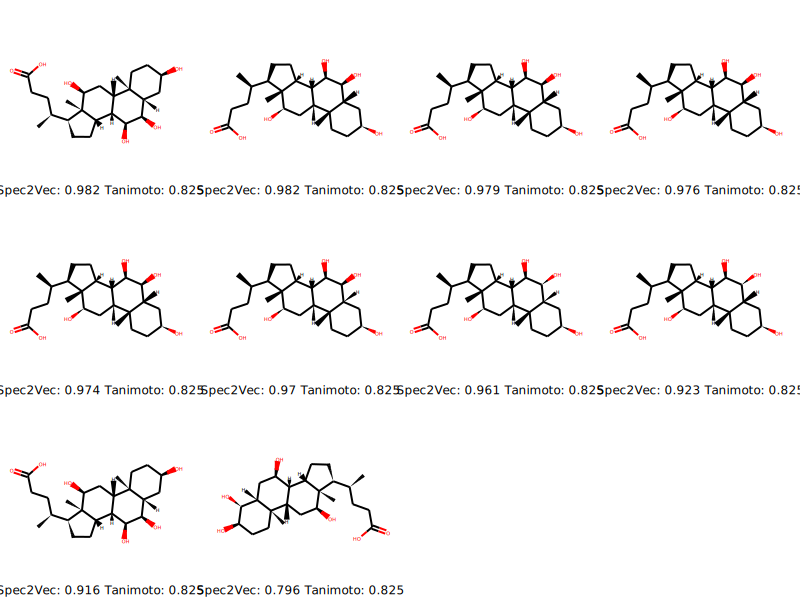

In [95]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
save_img_as_svg("found_molecules_query_{}.svg".format(ID), img)
img

## Examples where it "fails"


 ---------- Query molecule ----------
CN(C)C1=CC(Br)=CC=C1


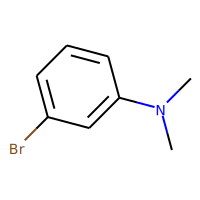

In [96]:
ID = 0  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
save_img_as_svg("molecule_query_{}.svg".format(ID), img)
img


 ---------- Suggested molecules ----------
COc1c2ccoc2cc2oc(C)cc(=O)c12
COc1cc2oc3c(Cl)c(OC)cc(C)c3c(=O)c2c(OC)c1Cl
COc1cc(-c2ccc(N)c(OC)c2)ccc1N
COc1cc(-c2ccc(N)c(OC)c2)ccc1N
COc1c2ccoc2cc2oc(C)cc(=O)c12
COC1=C2C=CC(=O)OC2=CC3=C1C=CO3
COc1ccc(-c2oc3cc4c(c(OC)c3c(=O)c2OC)OCO4)cc1
COC1=C2C=CC(=O)OC2=CC3=C1C=CO3
CSc1nc2ccccc2s1
CSc1nc2cc(Oc3cccc(Cl)c3Cl)c(Cl)cc2[nH]1


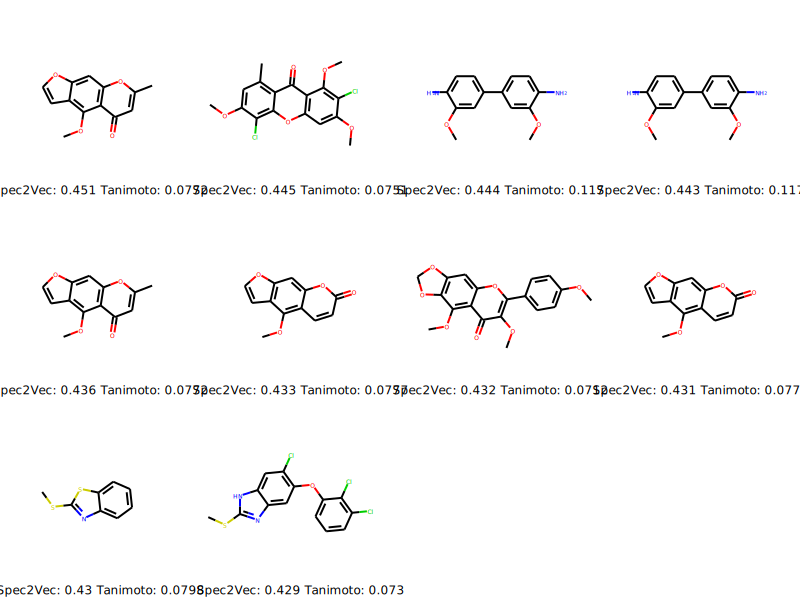

In [87]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
save_img_as_svg("found_molecules_query_{}.svg".format(ID), img)
img

## Ideas
+ I suspect that small molecules will lead to worse results

In [97]:
# Check why...
print(documents_query[ID]._obj.get("parent_mass"))
print("number of 'words' {}".format(len(documents_query[ID].words)))

198.99972354800926
number of 'words' 21


In [98]:
n_words = []
masses = []
for doc in documents_query:
    n_words.append(len(doc.words))
    masses.append(doc._obj.get("parent_mass"))

In [99]:
mol_sim_matches[610], len(n_words)

(array([[0.86195286, 0.86195286, 0.86195286, 0.86195286, 0.86195286,
         0.86195286, 0.86195286, 0.86195286, 0.86195286, 0.86195286]]),
 1030)

### Compare number of words vs match with structural similarity

Text(0, 0.5, 'structural similarity')

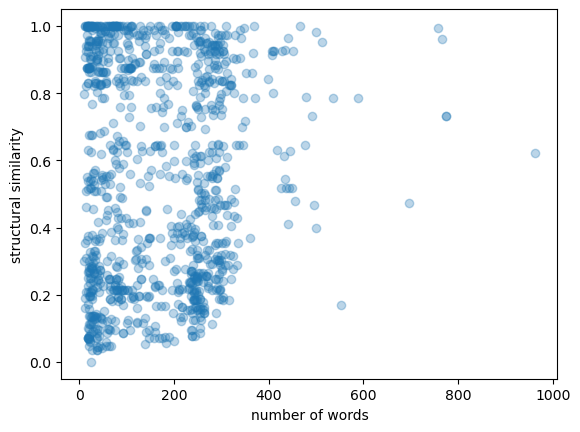

In [102]:
plt.scatter(np.asarray(n_words), np.asarray([x[0][0] for x in mol_sim_matches]), alpha=0.3)
plt.xlabel("number of words")
plt.ylabel("structural similarity")

### Compare precursor-m/z vs match with structural similarity

Text(0, 0.5, 'structural similarity')

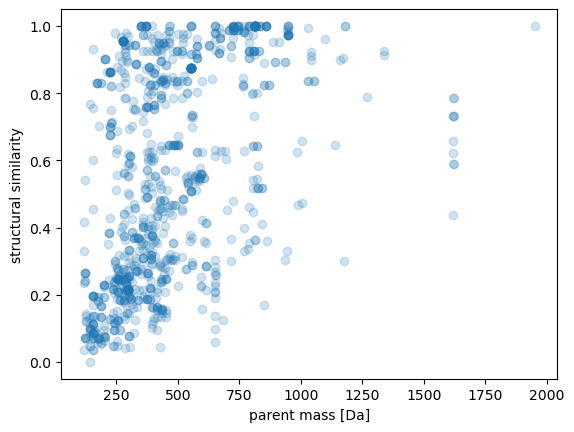

In [104]:
plt.scatter(np.asarray(masses), np.asarray([x[0][0] for x in mol_sim_matches]), alpha=0.2)
plt.xlabel("parent mass [Da]")
plt.ylabel("structural similarity")

In [139]:
mass_vs_similarity = pd.DataFrame(list(zip(masses,
                                           [x[0][0] for x in mol_sim_matches],
                                           [max(x[0]) for x in mol_sim_matches]
                                          )),
                                  columns=["parentmass", "tanimoto", "tanimoto_best_of_10"])

In [140]:
mass_bins = [0, 200, 400, 600, 800, 2000]
mass_bins_labels = ['{} - {}'.format(mass_bins[i], mass_bins[i+1]) for i in range(5)]
mass_vs_similarity["mass_bins"] = pd.cut(mass_vs_similarity["parentmass"], mass_bins, labels = mass_bins_labels)

In [141]:
mass_vs_similarity.head()

,parentmass,tanimoto,tanimoto_best_of_10,mass_bins
0,198.999724,0.077220,0.116751,0 - 200
1,198.999724,0.077220,0.116751,0 - 200
2,235.072724,0.046322,0.061758,200 - 400
3,117.992724,0.034247,0.594595,0 - 200
4,117.992724,0.417582,0.470149,0 - 200


Text(0.5, 1.0, 'Compound mass dependence of Spec2Vec unknown compound matching')

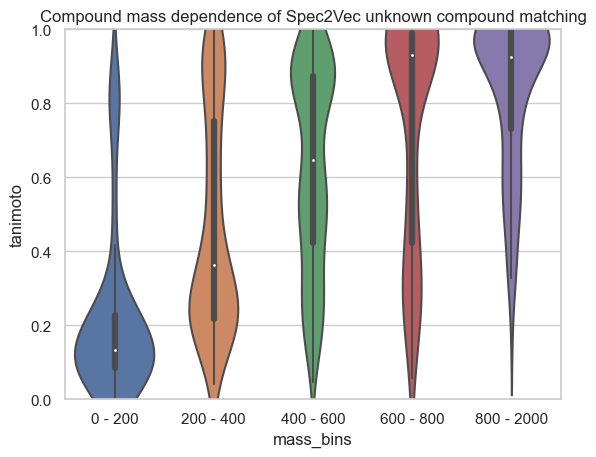

In [124]:
import seaborn as sns

sns.set(style="whitegrid")

ax = sns.violinplot(x="mass_bins", y="tanimoto", data=mass_vs_similarity)
ax.set(ylim=(0, 1.0))
plt.title("Compound mass dependence of Spec2Vec unknown compound matching")

## Plot highest scoring s2v per query in dependence of parentmass

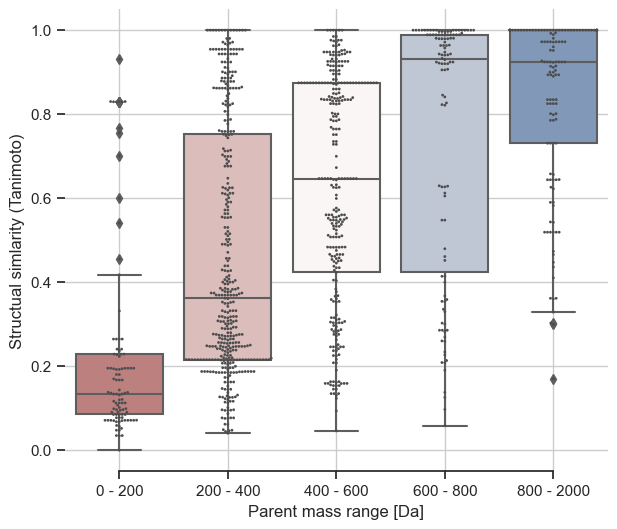

In [144]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="mass_bins", y="tanimoto", data=mass_vs_similarity, palette="vlag_r")

# Add in points to show each observation
sns.swarmplot(x="mass_bins", y="tanimoto", data=mass_vs_similarity,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="Structual simlarity (Tanimoto)")
ax.set(xlabel="Parent mass range [Da]")
sns.despine(trim=True, left=True)

plt.savefig("Unknown_compound_matching_parentmass_dependence_highest_s2v.pdf")

## Plot best pick out of top-10 s2v matches per query in dependence of parentmass

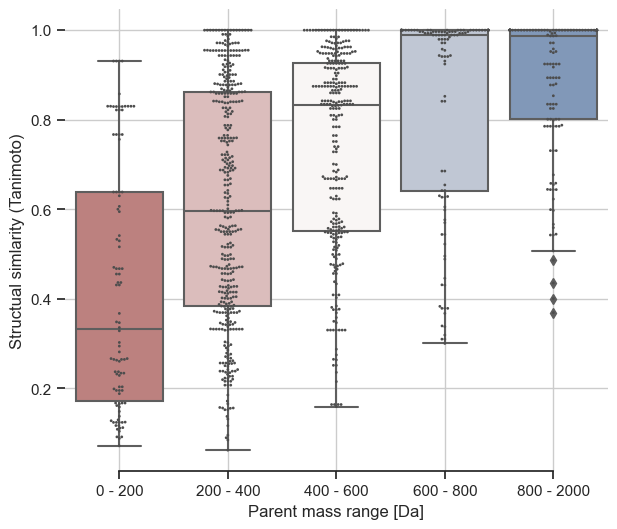

In [146]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="mass_bins", y="tanimoto_best_of_10", data=mass_vs_similarity, palette="vlag_r")

# Add in points to show each observation
sns.swarmplot(x="mass_bins", y="tanimoto_best_of_10", data=mass_vs_similarity,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.set(ylabel="Structual simlarity (Tanimoto)")
ax.set(xlabel="Parent mass range [Da]")
sns.despine(trim=True, left=True)

plt.savefig("Unknown_compound_matching_parentmass_dependence_best_of_10.pdf")
plt.savefig("Unknown_compound_matching_parentmass_dependence_best_of_10.svg")